In [1]:
import alpdesign
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import optimizers

### Initialize data

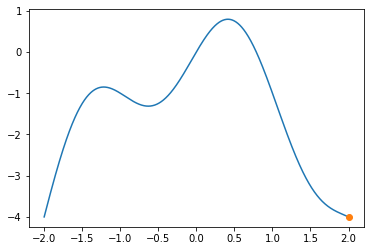

In [2]:
x = np.linspace(-2,2, 1000)
reps = np.array([2.0]).reshape(-1,1)
label_fxn = lambda x: np.sin(x * np.pi) - x ** 2
labels = label_fxn(reps)
plt.plot(x,  label_fxn(x))
plt.plot(reps, labels, 'o')

In [6]:
config = alpdesign.EnsembleBlockConfig()
forward_fxn, full_forward_fxn = alpdesign.build_model(config)
full_forward_t = hk.without_apply_rng(hk.transform(full_forward_fxn))
forward_t = hk.without_apply_rng(hk.transform(forward_fxn))

def loop(key, reps, params):
    key, train_key = jax.random.split(key, num=2)
    labels = label_fxn(reps)
    params, losses = alpdesign.ensemble_train(train_key, full_forward_t, config, reps, labels, params=params)
    # make random point
    init_x = jax.random.normal(key, (1,1))
    forward = partial(forward_t.apply, params)
    final_vec = alpdesign.mlp.bayes_opt(forward, labels, init_x=init_x)
    # compute plot
    yhat_mu, yhat_std = [], []    
    for xi in x:
        v = forward(xi[np.newaxis])
        yhat_mu.append(float(v[0]))
        yhat_std.append(float(v[1]))
    
    reps = jnp.concatenate((reps, final_vec))
    return key, reps, yhat_mu, yhat_std, final_vec, params
    
    

In [7]:
key = jax.random.PRNGKey(0)

yhat_mus = []
yhat_stds = []
final_vecs = []
repss = []
params = None
for i in range(10):
    print(i)
    key, reps, yhat_mu, yhat_std, final_vec, params= loop(key, reps, params)
    print(final_vec)
    yhat_mus.append(yhat_mu)
    yhat_stds.append(yhat_std)
    final_vecs.append(final_vec)
    repss.append(reps)
    

0
[[-0.02375016]]
1
[[0.00064385]]
2
[[0.00622414]]
3
[[0.74559975]]
4
[[-3.2253723]]
5
[[-3.1736515]]
6
[[-1.3558908]]
7
[[-0.81901246]]
8
[[0.06477457]]
9
[[0.06441063]]


0
1
2
3
4
5
6
7
8
9


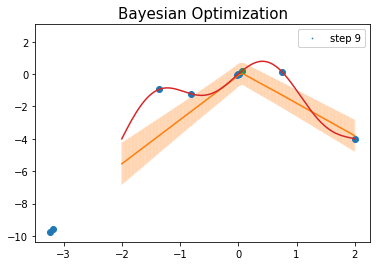

In [8]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(10):
    plt.plot(np.squeeze(repss[i][:-1]), label_fxn(np.squeeze(repss[i][:-1])), 'o', color='C0')
    plt.plot(x, yhat_mus[i], color='C1')
    #plt.xlim(0,1)
    #print(x.shape)
    #print()
    print(i)
    plt.plot(final_vecs[i][0], label_fxn(final_vecs[i][0]), '*', color='C2')
    plt.plot(x, label_fxn(x), color='C3')
    plt.errorbar(x, yhat_mus[i], yerr=yhat_stds[i], color='C1', alpha=0.05)
    plt.legend(['step %d' % (i)] , markerscale=0.1)
    plt.title('Bayesian Optimization', fontsize=15)
    camera.snap()
animation = camera.animate(interval = 1000, repeat = True,
                           repeat_delay = 500)
animation.save('BO.gif', writer = 'imagemagick', dpi=180)